In [1]:
import os
print(os.getcwd())

/home/jovyan/59min/final


In [2]:
#!pip install torch==2.5.0+cu121 torchaudio==2.5.0+cu121 torchvision==0.20.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install transformers
#!pip install openpyxl
#!pip install rank-bm25

In [3]:
from transformers import BertTokenizer
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import openpyxl
import ast
import torch.optim as optim

# 데이터 준비

## Dataset 1: 키워드화 된 데이터셋 가져오기

In [4]:
# 엑셀 파일 불러오기
file_path_full = '/home/jovyan/59min/Bert4Rec/Performance_evaluation_dataset/Korea_full_sentence.xlsx'  # 파일 경로

df_full = pd.read_excel(file_path_full)

In [5]:
df_full = df_full.rename(columns={'keywords':'label'})

In [6]:
# 엑셀 파일 불러오기
file_path_user_sequence= '/home/jovyan/59min/model/user_sequence_ko.xlsx'  # 파일 경로
df_seq = pd.read_excel(file_path_user_sequence)

df_seq = df_seq.drop(columns=['Unnamed: 0'])

In [7]:
df_full

,선택 이유,베뉴 이름
0,홀 내부- 단독홀로 타 하객들과 섞이지 않고 비교적 넉넉한 시간동안 이용할 수 있다...,빌라드지디 수서
1,저희 커플이 홀 선택 시 고려했던 점은 예쁜 홀 + 맛있는 식사였습니다.(1) 홀 ...,더링크호텔 가든홀
2,"인천에서 가장 많이 한다는 네임밸류, 검증된 식사 퀄리티 결정적으로 신부가 홀에 마...",메리빌리아 셀레스메리홀
3,밝은홀의 장점과 어두운 홀의 장점 모두 아우르고 있는것 같아서 선택! ( 자세한 사...,노블발렌티 삼성점
4,저희가 보증인원 100-150명이 가능한 홀을 찾다보니 옵션이 많이 않았습니다.소규...,국방 컨벤션
...,...,...
292,사랑스러운 분위기의 홀이 제일 먼저 눈에 들어왔어요- 하객의자가 예쁘고 숲속느낌이 ...,수원 파티움 하우스
293,"몇 번 하객으로 왔던 경험 상 무난하다고 생각했고, 식장과 음식 퀄리티는 보장된다고...",신도림 라마다 5층 세인트그레이스홀
294,저희는 우선 하객들에게 식사를 대접하는 예식을 가장 우선으로 꼽아서 플래너님에게도 ...,웨딩여율리
295,"강남에 위치한 채플형 웨딩홀을 원했기 때문에 아펠가모 2곳 (선릉, 반포) + 더채...",더채플앳논현 라메르홀


In [8]:
df_seq

,user_id,list,keyword
0,0,"['국방 컨벤션', '빌라드지디 수서', '라비두스', '시그니엘', '신도림 더 ...",예쁜 홀
1,1,"['더링크호텔', '더컨벤션 신사']",예쁜 홀
2,2,"['더링크호텔 가든홀', '더마레보호텔&웨딩', '아펠가모 선릉']",예쁜 홀
3,3,"['노블발렌티 삼성', '양재 엘블레스', '잠실 아펠가모 웨딩홀', '구로 지타워...",예쁜 홀
4,4,"['신도림 테크노마트 웨딩시티', '서울대 이라운지', '♥ 노블발렌티 삼성점']",예쁜 홀
...,...,...,...
645,645,"['노블발렌티 삼성역점', '노블발렌티 삼성']",신부 대기
646,646,"['국방 컨벤션', '루벨 강동']",신부 대기
647,647,"['크레스트72 글라스홀', '양재 엘타워 그랜드홀']",신부 대기
648,648,"['양재 엘타워 그랜드홀', '노블발렌티 삼성', '더파티움 안양(구 아르떼)', ...",신부 대기


In [9]:
class BERT4RecDataset(Dataset):
    def __init__(self, data, max_seq_len=10, mask_prob=0.15):
        self.user_sequences = data['list'].apply(ast.literal_eval)  # 시퀀스를 리스트 형태로 변환
        self.mask_prob = mask_prob
        self.max_seq_len = max_seq_len
        self.venue_names = list(set([venue for seq in self.user_sequences for venue in seq]))  # 모든 venue 리스트화
        self.vocab_size = len(self.venue_names)
        self.data = self.prepare_data()

    def prepare_data(self):
        data = []
        for seq in self.user_sequences:
            indexed_seq = []
            for item in seq:
                if item in self.venue_names:
                    indexed_seq.append(self.venue_names.index(item))
                else:
                    print(f"Warning: {item} is not in venue_names, replacing with [UNK]")
                    indexed_seq.append(self.vocab_size - 1)  # [UNK] 토큰으로 대체

            # 패딩 또는 잘라내기
            if len(indexed_seq) < self.max_seq_len:
                indexed_seq = [0] * (self.max_seq_len - len(indexed_seq)) + indexed_seq  # 패딩
            else:
                indexed_seq = indexed_seq[:self.max_seq_len]
            data.append(indexed_seq)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        input_ids = torch.tensor(seq, dtype=torch.long)
        labels = torch.tensor(seq, dtype=torch.long)
        masked_input = input_ids.clone()
        mask = torch.zeros_like(input_ids, dtype=torch.bool)

        # 마스킹 로직
        for i in range(len(seq)):
            if random.random() < self.mask_prob:
                mask[i] = True
                prob = random.random()
                if prob < 0.8:
                    masked_input[i] = self.vocab_size - 1  # 마스킹 토큰 추가
                elif prob < 0.9:
                    masked_input[i] = random.choice(list(range(self.vocab_size)))  # 랜덤하게 다른 토큰 선택

        return masked_input, labels, mask


In [10]:
# BERT4Rec 모델 정의 (간단화된 BERT 구조)
class BERT4RecModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=2, max_seq_len=10, dropout=0.1):
        super(BERT4RecModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, input_ids):
        positions = torch.arange(0, input_ids.size(1)).unsqueeze(0).to(input_ids.device)
        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        logits = self.fc(x)
        return logits

In [11]:
# 데이터셋 로드 및 DataLoader 설정
dataset = BERT4RecDataset(df_seq)  # user_sequences_df: 유저 시퀀스가 포함된 데이터프레임
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 모델 초기화
vocab_size = len(dataset.venue_names)
model = BERT4RecModel(vocab_size=vocab_size)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/home/jovyan/.venv/torch2.3.0-py3.11-cuda12.1/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
# 모델 저장 경로 설정
model_save_path = 'bert4rec_model_ko.pth'


In [13]:
# 모델의 가중치 저장
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

Model saved to bert4rec_model_ko.pth


# 추론

In [14]:
model = BERT4RecModel(vocab_size=vocab_size)
model.load_state_dict(torch.load(model_save_path))

print("Model loaded from", model_save_path)

Model loaded from bert4rec_model_ko.pth


/home/jovyan/.venv/torch2.3.0-py3.11-cuda12.1/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### BM25 필터링

In [15]:
from rank_bm25 import BM25Okapi

# 예시 리뷰 데이터
reviews = df_full['선택 이유'].tolist()

# 토큰화 및 BM25 모델 생성
tokenized_reviews = [str(review).split(" ") if isinstance(review, str) else "" for review in reviews]
bm25 = BM25Okapi(tokenized_reviews)

# 쿼리
queries = ["주차 편리"]
filtered_indices = set()

# 각 쿼리에 대해 BM25 점수 계산 및 필터링
for query in queries:
    query_tokens = query.split(" ")
    scores = bm25.get_scores(query_tokens)
    query_filtered_indices = [i for i, score in enumerate(scores) if score > 0]
    filtered_indices.update(query_filtered_indices)  # 중복되지 않도록 인덱스를 집합에 추가

# 필터링된 인덱스로 데이터 추출
filtered_reviews = df_full.iloc[list(filtered_indices)].reset_index(drop=True)
print(" '주차 편리' 키워드로 필터링 된 리뷰들:", filtered_reviews)


 '주차 편리' 키워드로 필터링 된 리뷰들:                                                 선택 이유                 베뉴 이름
0   수원에서 예식하기로 생각했고 저희는 아무래도 친척이 각각 파주, 부산에 거주하고 계...             수원 디에스컨벤션
1   올해 2월달에 예식장 상담을 받았는데 이제야 후기를 작성해봅니다ㅎㅎㅎ 더컨벤션 잠실...                웨딩 여율리
2   이전 후기에도 적었듯 하객으로 왔을 때 아주 맘에 들었던 홀입니다 ㅎㅎ 다른 하객분...              신도림 더세인트
3   그랜드볼룸홀이 크고 웅장한 느낌이라 호텔예식을 합리적인 가격으로 원하시는 분들에게 ...       신도림 웨딩시티 그랜드볼룸홀
4   더컨벤션 영등포 점은 2순위였는데 여기가 먼저 가격,예약이 오픈되어서 방문했다가 괜...  더컨벤션 영등포 (1F 그랜드볼룸홀)
5   엘타워가 식사가 맛있고 주차 와 교통이 편리한 곳으로 이미 유명하더라고요.직접가서 ...             엘타워 그레이스홀
6   수원 지역부터 강남 지역까지 한 6개 웨딩홀 투어를 했었는데 마음에 드는 걸 찾지 ...             더마레보호텔&웨딩
7   안녕하세요 내년 4워러 결혼을 앞둔 예비 신부입니다. 저희는 각자 본가 위치 때문에...              더리버사이드호텔
8   삼성역으로 접근성이 가장 좋다는 점이 끌렸습니다. 저는 소노펠리체컨벤션과 더컨벤션신...              소노펠리체컨벤션
9   안녕하세요 저는 9월 말에 결혼을 앞둔 예비신랑이에요. 여자친구와 제가 중요하게 생...                  라비니움
10  밥이 맛있고 주차 공간(1,400대 정도) 넉넉할 것!신랑측, 저희 측 합쳐서 하객...    루이비스컨벤션 송파문정 그레이스홀
11  밝은홀을 찾고 있었는데, 마침 내년에 공사가 시작를 한다는 말에 어! 여기다 라는 ...       라마다

In [16]:
print(scores)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         2.00271304 0.
 0.         2.74681508 0.         0.         0.         0.
 0.         0.         1.86778603 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.51139535 0.         0.         0.
 0.         0.         0.         0.         0.         1.84704612
 0.         0.         0.         0.         0.         0.
 0.         0.         1.73167498 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 2.49693354 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.2362033  0.         2.18703373 0.         0.
 0.         0.         0.         0.         2.99401929 0.
 0.         0.         0.         1.9556223  0. 

In [17]:
filtered_reviews

,선택 이유,베뉴 이름
0,"수원에서 예식하기로 생각했고 저희는 아무래도 친척이 각각 파주, 부산에 거주하고 계...",수원 디에스컨벤션
1,올해 2월달에 예식장 상담을 받았는데 이제야 후기를 작성해봅니다ㅎㅎㅎ 더컨벤션 잠실...,웨딩 여율리
2,이전 후기에도 적었듯 하객으로 왔을 때 아주 맘에 들었던 홀입니다 ㅎㅎ 다른 하객분...,신도림 더세인트
3,그랜드볼룸홀이 크고 웅장한 느낌이라 호텔예식을 합리적인 가격으로 원하시는 분들에게 ...,신도림 웨딩시티 그랜드볼룸홀
4,"더컨벤션 영등포 점은 2순위였는데 여기가 먼저 가격,예약이 오픈되어서 방문했다가 괜...",더컨벤션 영등포 (1F 그랜드볼룸홀)
5,엘타워가 식사가 맛있고 주차 와 교통이 편리한 곳으로 이미 유명하더라고요.직접가서 ...,엘타워 그레이스홀
6,수원 지역부터 강남 지역까지 한 6개 웨딩홀 투어를 했었는데 마음에 드는 걸 찾지 ...,더마레보호텔&웨딩
7,안녕하세요 내년 4워러 결혼을 앞둔 예비 신부입니다. 저희는 각자 본가 위치 때문에...,더리버사이드호텔
8,삼성역으로 접근성이 가장 좋다는 점이 끌렸습니다. 저는 소노펠리체컨벤션과 더컨벤션신...,소노펠리체컨벤션
9,안녕하세요 저는 9월 말에 결혼을 앞둔 예비신랑이에요. 여자친구와 제가 중요하게 생...,라비니움


### 추천 결과 추론

In [18]:
def predict_next_items(model, user_sequence, filtered_reviews, dataset, max_seq_len=10, top_k=10):
    # 전체 venue 이름을 dataset에서 가져옴
    venue_names = dataset.venue_names

    # 입력 시퀀스를 인덱스로 변환하고 패딩 적용
    indexed_seq = [venue_names.index(item) if item in venue_names else len(venue_names) - 1 for item in user_sequence]
    if len(indexed_seq) < max_seq_len:
        indexed_seq = [0] * (max_seq_len - len(indexed_seq)) + indexed_seq  # 앞쪽에 패딩 추가
    else:
        indexed_seq = indexed_seq[-max_seq_len:]  # 최근 max_seq_len만 사용

    # 모델 입력 형태로 변환 (배치 차원 추가)
    input_ids = torch.tensor(indexed_seq, dtype=torch.long).unsqueeze(0).to(next(model.parameters()).device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        logits = model(input_ids)
        predictions = logits[0, -1]  # 마지막 위치의 예측 결과

    # 상위 top_k개의 추천 venue 인덱스
    top_k_indices = predictions.topk(top_k).indices.tolist()
    recommended_items = [venue_names[idx] for idx in top_k_indices if idx < len(venue_names)]
    print(top_k_indices)

    # filtered_reviews에 추천된 venue만 반환
    final_recommendations = [item for item in recommended_items if not filtered_reviews[filtered_reviews['베뉴 이름'] == item].empty]

    return final_recommendations



In [ ]:
# 예시 호출
user_sequence = ['부천 소풍 웨딩홀', '더세인트 그랜드볼룸홀','아펠가모 광화문점']  # 유저 시퀀스 예시
recommended_items = predict_next_items(model, user_sequence, filtered_reviews, dataset)
print("Recommended items:", recommended_items)

[44, 28, 41, 133, 38, 52, 46, 96, 134, 94]
Recommended items: ['신도림 웨스턴 베니비스']


In [20]:
print("추천 콘텐츠: ", recommended_items)

추천 콘텐츠:  ['신도림 웨스턴 베니비스']


# 결과 비교

In [21]:
# 데이터프레임에서 user_sequence에 해당하는 name 필터링
filtered_df = df_full[df_full['베뉴 이름'].isin(user_sequence)]
infer_filtered_df=df_full[df_full['베뉴 이름'].isin(recommended_items)]

In [22]:
filtered_df

,선택 이유,베뉴 이름
117,아펠가모는 홀투어 상담 없이도 아펠가모 홈페이지에 가입하면 화면처럼 이렇게 날짜별로...,아펠가모 광화문점
128,저희가 희망했던 예식 날짜가 마침 남아 있었고(덕분에 저희가 처음 사귀게 된 날이 ...,더세인트 그랜드볼룸 홀
228,아펠가모로 정하자마자 아페락모 사이트를 먼저 들어가봤습니다.사이트에서 견적을 다 확...,아펠가모 광화문점
245,"식을 부천에서 올려야 해 부천 웨딩홀 위주로 알아보았고 후보는 MJ, 삼산체육관웨딩...",부천 소풍 웨딩홀


In [23]:
infer_filtered_df

,선택 이유,베뉴 이름
53,웨스턴베니비스(신도림)웨딩홀 는 주차와 식사 위치 홀 분위기를 중점적으로 봤습니다....,신도림 웨스턴 베니비스
157,일단 서울 홀투어를 할 예정이라 차를 가져가지 않았었습니다. 지하철역에서 7분정도?...,신도림 웨스턴 베니비스


In [24]:
def user_liking_list(df):
    with pd.option_context('display.max_colwidth', None):
        display(df)


In [25]:
user_liking = user_liking_list(filtered_df)

,선택 이유,베뉴 이름
117,"아펠가모는 홀투어 상담 없이도 아펠가모 홈페이지에 가입하면 화면처럼 이렇게 날짜별로 견적이랑 세부내용 확인할 수 있거든요. 부대상품이 너무 마음에 들었어요 웨딩홀이랑 신부대기실 생화장식이랑 전문사회자, 피아노 3중주가 포함되어있고 본식영상촬영이랑 웨딩케어 트리츠스파 2회 이용권까지 제공된다는점!!ㅡ 아펠가모가 워낙 식사로 맛있기로 유명하지만 광화문점은 막걸리와 생맥주가 무한으로 가능하고 바로바로 요리해주시는 메뉴가 많은 것 같아요. 피자도 화덕에 구워 바로 나온다고 하고, LA갈비도 바로 구워주더라구요. 면요리도 즉석에서 바로바로 해준대요. 초대하는 부모님 하객분들이 좋아하실듯 해요ㅡ 페백도 할 계획인데 폐백실 괜찮은곳 찾기 은근 어렵더라구요 ㅠㅠ 여기는 한옥 느낌으로 폐백실도 잘 되어있고전통 궁중혼례복 입고 사진도 찍어볼수 있다고 해서 선택했습니다.- 제니하우스에서 운영하는 혼주 헤어&메이크업샵이 입점되어 있더라구요. 부모님들은 여기서 헤메 받으시면 편할 것 같아요.ㅡ 그 외에도 양가 집이랑 멀지 않고 채플형 느낌의 단독홀도 마음에 들었고 주차도 편리해서 좋을거 같았습니다",아펠가모 광화문점
128,"저희가 희망했던 예식 날짜가 마침 남아 있었고(덕분에 저희가 처음 사귀게 된 날이 결혼기념일이 될 것 같네요.!), 전체적인 가격대가 저희가 생각한 예산에 부합해서 최종 결정하게 되었습니다~홀은 지하1층에 위치한 그랜드컨벤션 홀과 지상2층에 위치한 파티움홀이 있었고, 홀 투어 당시 두 곳을 모두 보았습니다. 사실 저희는 어두운 홀로 거의 생각을 정리했었기에 밝은 홀인 파티움홀은 큰 기대가 없었는데 막상 보니 생각한 것보다 너무 근사했습니다.꽃장식도 화사한 느낌이었고(이건 바뀔 수 있다 하시지만 항상 밝은 분위기로 꾸며주시는 듯 했습니다) 무엇보다 신부 입장에 맞추어 암막커튼이 걷히면서 자연채광이 들어오는 것이 가장 큰 매력이었어요. 밝은 홀이 아무래도 집중이 분산되는 단점이 있겠다 싶었는데 커튼을 잘 활용하면 충분히 집중도를 높일 수 있겠더라구요. 저희는 결론적으로 이 홀을 선택하지는 않았지만 마지막까지도 고민 많이 했던 것 같아요 ㅠㅠ* 그랜드컨벤션 홀저희가 선택한 그랜드컨벤션 홀은 어두운 홀의 정석인 느낌이고, 층고가 높아 웅장한 느낌도 들었습니다. 저희가 가장 맘에 들었던 부분은 전면부 스크린인데요. 홀투어 다니면서 스크린이 홀 한쪽 벽면에 내려와서 영상을 틀어주는 형태를 많이 보았는데, 그랜드컨벤션 홀은 그런 걱정 없이 전면부 스크린 양 사이드쪽에서 큰 화면으로 식전영상 및 식중영상을 재생할 수 있었답니다. 하객석 어느 자리에서든 스크린이 시원하게 보여서 저희는 너무 만족했던 것 같아요. 식 중간 중간에도 화면이 계속 바뀌면서 식순과 맞는 분위기로 연출되었던 점도 좋았어요.그랜드컨벤션홀 버진로드는 꽤 긴 편이고, 저희가 맘에 들었던 부분은 폭이 넓다는 부분이었어요. 요새는 신랑, 신랑아버지 동시입장, 양가 부모님 동시입장 이런 연출을 많이 하잖아요. 두명이서 나란히 버진로드를 걷는다고 해도 답답해보이는 느낌이 없고 넉넉하게 입장할 수 있겠더라구요. 물론 그랜드컨벤션홀은 전면부 스크린이 열리면서 신랑이 등장하는 방식으로 신랑입장을 연출할 수 있는데요. 많은 신랑 분들이 앞에서 등장하는 방식을 선택하신다고 하더라구요? 아무래도 이 홀만이 가진 특징이니까! 저희도 잘 고민해봐야겠어요 ㅎㅎ지하에 위치해있지만 건물에 들어오자마자 에스컬레이터가 바로 보여서 그대로 내려오면 홀이기 때문에 지하라는 느낌이 전혀 안드는 그랜드컨벤션홀 너무 맘에듭니다.!* 신부대기실더파티움의 신부대기실은 두가지 홀이 모두 웅장해요. 파티움홀을 선택한 신부님들이 사용하는 대기실은 제가 본 예식장 중에 제일 컸어요. 신부대기실에 신부만 있는 것이 아닌 가족들도 함께 대기하면서 신부 긴장을 풀어주는 것이 너무 보기 좋아보였네요(물론 서브 대기실도 꽤 넓게 마련되어 있답니다)저희가 선택한 그랜드컨벤션홀 신부대기실도 층고가 높고 전체적으로 화이트톤을 가지면서 어울리게 장식된 꽃들이 돋보이도록 꾸며져 있었어요. 신부대기실 동선도 좋고 신부대기실 자체가 넓은 편이어서 신부대기실을 찾아주시는 손님들이 대기를 하시게 되더라도 불편함이 전혀 없을 것 같아요.* 연회장연회장은 지하1층에 위치해있어요. 지하1층 그랜드컨벤션 홀을 선택하게 되면 하객분들이 층 이동 없이 바로 연회장을 이용하실 수 있답니다. 연회장에 들어가게 되면 몇시 예식의 하객인지 안내판을 확인하고 왼쪽 혹은 오른쪽으로 안내받게 됩니다. 아예 이동방향이 다르고 식사 공간도 분리되기 때문에 다른 예식과 하객이 겹칠 걱정은 안 되더라구요.저희가 선택할 때 연회장 관련해서 고민했던 부분이 한상+세미뷔페 형태였던 부분이었어요. 근데 직접 보니까 양도 푸짐하고 몇가지 음식을 제외하고는 리필도 가능하다고 하더라구요. 식사를 할 때도 특별히 이동하지 않고 제자리에서 리필을 받는 형식이라는 점에서 예식 후 신랑신부가 인사를 드리러 다닐 때도 하객들이 자리를 비우는 일이 전혀 없겠더라구요. 제가 보러갔을 때에도 하객이 정말 많았는데 세미뷔페 이용인원을 제외하고는 이동하는 사람이 거의 없어서 정신없지 않더라구요. 혼주 및 가족 친지들이 식사하는 공간도 한쪽에 넓게 마련되어 있답니다. 하객으로 방문했던 지인한테 물어보니 밥을 맛있게 먹었던 걸로 기억한다고 하더라구요!? 저희는 하객으로 방문한 적은 없어서 빨리 시식해보고 싶네요 ㅎㅎ",더세인트 그랜드볼룸 홀
228,"아펠가모로 정하자마자 아페락모 사이트를 먼저 들어가봤습니다.사이트에서 견적을 다 확인 할 수 있어서 다른 예식장에 비해 가격을 투명하게 알 수 있어서더 신뢰가 갔습니다 ㅎㅎㅎㅎ 다른 식장들은 부르는게 값이고 가서 견적받으면 받는 사람마다 다 다르길래 걱정했었는데 사이트에 가격이 다 공개되니 더 좋았던 것 같습니다.홈페이지에서 바로 예약은 가능하지만, 첫 투어라 설명듣고 실제로 식장을 보고싶어서 바로 바로 홀투어 예약했습니다.가자마자 너무 친절하게 맞이해주셔서 너무 기분이 좋아졌고, 첫 방문이여서 하나부터 열까지 세세하게 설명을 들었습니다. 우선 무엇보다 아펠가모는 밥펠가모로 유명하여 연회장에서도 기대만큼 밥들이 맛있어 보였습니다.구경하고 당일예약을 하면 여라가지 혜택을 주신다고 하셨는데 가격+혜택 생각해보면 안 할 이유가 없어저녁에 바로 당일 예약까지 !!집에 갈때 꽃 한송이와 스타벅스 금액권을 주셨는데 너무 감동받았습니다... 뭔가 거길 다녀오면서 하루종일 기분이 좋았던 것 같습니다.",아펠가모 광화문점
245,"식을 부천에서 올려야 해 부천 웨딩홀 위주로 알아보았고 후보는 MJ, 삼산체육관웨딩홀, 소풍 웨딩홀 세군데였습니다.저희의 기준은 어두운 홀, 식사 맛, 주차 3가지 였는데, 그 기준에 충족하는 웨딩홀이 소풍 웨딩홀이었어요!소풍웨딩홀은 베일리 홀(밝은 홀), 라온제나 홀(어두운 홀) 관이 2개 였는데 뷔페는 한곳에서 두 홀의 식사를 같이 진행하지만 예식시간이나 하객 식사 시간이 겹치지 않아 그것도 마음에 들었습니다.지난 주에 시식 다녀왔는데 맛도 기대 이상이었고 음식 종류가 지인짜 많아서 놀랐어요!하객 분들 배터지게 드시겠구나 싶었습니다ㅎㅎㅎ그리고 소풍 웨딩홀은 다 마음에 들었는데 백화점과 터미널이 연결되어 있어 주차를 가장 걱정했거든요..그래서 주말 예식 피크타임때 도보와 차량 이용해 다녀와보았는데 주차도 생각보다 금방했고 도보로 갔을 땐 백화점 통해 올라가는데 정문앞에 웨딩홀 직원분이 안내를 해주셔서 어렵지않게 찾아 갈 수 있었어요!본식 한달 남았는데 잘 치르고 또 후기도 남길게요!시식날 사진을 못찍어 아래 사진은 웨딩홀 홈페이지에서 발췌한 사진입니다.",부천 소풍 웨딩홀


In [26]:
inference_liking = user_liking_list(infer_filtered_df)

,선택 이유,베뉴 이름
53,"웨스턴베니비스(신도림)웨딩홀 는 주차와 식사 위치 홀 분위기를 중점적으로 봤습니다. 고급스럽고 클래식한 분위기, 분리예식 웨딩홀이라는 장점과 홀마다 위치가 떨어져 있어서 하객들이 섞일 염려는 없다고 생각했습니다. 주차 같은 경우도 다른 웨딩홀 같은 경우 주차시간이 짧거나 주차공간이 여유롭지 못하여 오는 하객들에게 불편함이 없었으면 좋겠다는 생각이 들었습니다. 전철을 타고 오거나 자차를 타고 와도 2500대 충분한 주차공간, 연회장 안에 메뉴도 130가지 이상 준비 되어 하객들이 맛있게 먹고 갈 수 있는 웨딩홀을 찾았습니다. 제가 느낀 웨스턴베니비스는 식사, 위치, 주차, 견적, 웨딩홀, 신부대기실, 연회장, 폐백실 등 모든 것을 고려했을때 어느 부분 하나 단점이 없는 웨딩홀이라고 느껴서 웨스턴베니비스 웨딩홀 신도림점으로 계약했습니다.",신도림 웨스턴 베니비스
157,"일단 서울 홀투어를 할 예정이라 차를 가져가지 않았었습니다. 지하철역에서 7분정도? 걸어가면 끝에 위치해 있어서 직진만하면 되어서 괜찮겠다 싶었어요. 근데 재밌는건 상담 끝나고 돌아가는길에 지하철역에서 할머님이 호텔이름 핸드폰으로 보여주시면서 어디로 가야하냐구 하시더라구요 ㅎㅎ 아무래도 어르신들은 헷갈리실수 있겠구나 싶었습니다 리버사이드 호텔은 가족들이랑 식사할 때 몇번 가봐서 주차가 발렛 나오는데도 크게 오래걸리지 않았었는데 제가 방문한 일요일 11시임에도 불구하고 골목부터 길까지 쭉 막혀서 기다리면서 차들이 들어오는것을 봤습니다. 아침 11시인데 이렇게 복잡하다구..? 했는데 아무래도 뷔페 이용고객 결혼식 하객들이 합쳐지다보니 딜레이가 좀 있는것 같았습니다. + 대형관광버스들이 가는길목에 3대나 주차가 되어있어 처음오시는 분들은 한참 기다렸다가 나중에 알고 들어가는것 같았어요 상담 들어가선 콘서트홀만 볼생각이라 투어 도와주셨고, 생각보다 신부대기실이 넘 깔끔해서 괜찮다 싶었습니다. 낮은 층고는 어쩔수 없지만 홀내부에 들어가면 나름 높은 천장으로 개방감이 느껴져 괜찮았고 버진로드 길이도 길어보였습니다! 대기실에서 바로 입장이 가능하고, 식사는 한층 내려간 연회장에서 가능합니다. 생중계 되고 있었으나 화질이 크게 좋거나 가까이 있진않았습니다. 식사 컨디션은 그래도 나름 배부르게 드시고 가시겠구나 싶었습니다. 가든뷔페랑 웨딩이랑은 조금 다르게 운영된다고 하더라구요 연회장사진은 하객들이 있어 혼주 좌석으로 찍었습니다~ 견적도 합리적이고 발렛주차만 감당 가능하신분들에겐 괜찮은 베뉴일것 같습니다~! *타인의 이미지, 글 무단 사용 및 도용 금지 *타인의 이미지, 컨텐츠를 사용할 때는 꼭 출처를 명시해주세요. *정보 공개를 원치 않으시면 꼭 멤버 공개로 설정해 주세요.",신도림 웨스턴 베니비스


# 평가지표

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics functions
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    hits = set(recommended_k) & set(relevant)
    return len(hits) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0
    recommended_k = recommended[:k]
    hits = set(recommended_k) & set(relevant)
    return len(hits) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(recommended_k) if item in relevant])
    idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0

def hit_rate_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return int(bool(set(recommended_k) & set(relevant)))

def mrr_at_k(recommended, relevant, k):
    for idx, item in enumerate(recommended[:k]):
        if item in relevant:
            return 1 / (idx + 1)
    return 0


In [28]:
# Visualization of evaluation metrics
def plot_evaluation_metrics(recommended, relevant, max_k=5):
    k_values = range(1, max_k + 1)
    precision_scores = [precision_at_k(recommended, relevant, k) for k in k_values]
    recall_scores = [recall_at_k(recommended, relevant, k) for k in k_values]
    ndcg_scores = [ndcg_at_k(recommended, relevant, k) for k in k_values]
    hit_rate_scores = [hit_rate_at_k(recommended, relevant, k) for k in k_values]
    mrr_scores = [mrr_at_k(recommended, relevant, k) for k in k_values]

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, precision_scores, marker='o', label='Precision@K')
    plt.plot(k_values, recall_scores, marker='o', label='Recall@K')
    plt.plot(k_values, ndcg_scores, marker='o', label='NDCG@K')
    plt.plot(k_values, hit_rate_scores, marker='o', label='Hit Rate@K')
    plt.plot(k_values, mrr_scores, marker='o', label='MRR@K')

    plt.xlabel('K')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics for Top-K Recommendations')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


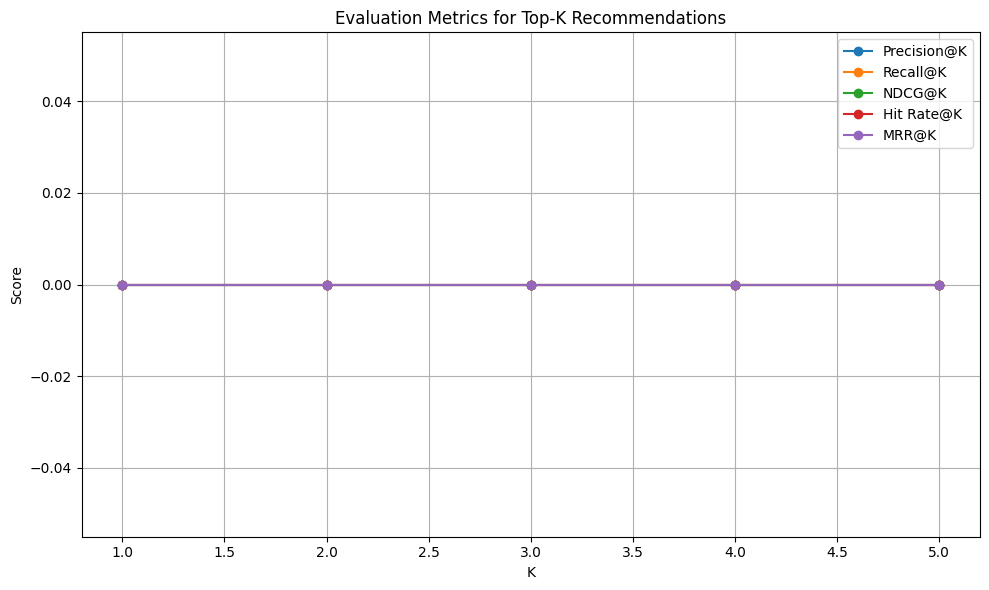

In [29]:

# Example usage
plot_evaluation_metrics(recommended_items, user_sequence, max_k=5)

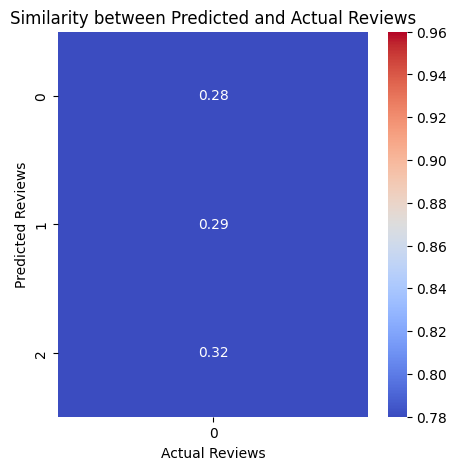

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# 문장을 BERT 임베딩으로 변환하는 함수
def get_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

# 예측 리뷰와 실제 리뷰 간의 유사도 계산 함수
def calculate_similarity(filtered_reviews, rec_result, model, tokenizer):
    
    # 예측 리뷰 임베딩 계산
    predicted_reviews = filtered_reviews['선택 이유'][:3].tolist() # 3개
    predicted_embeddings = get_embeddings(predicted_reviews, model, tokenizer)
    
    # 실제 리뷰를 rec_df의 'label' 열에서 가져와 임베딩 계산
    # actual_reviews = rec_result['장점'][2:].tolist() # 8개
    actual_embeddings = get_embeddings(recommended_items, model, tokenizer)
    
    # 코사인 유사도를 이용하여 두 임베딩 간 유사도 계산
    similarities = cosine_similarity(predicted_embeddings, actual_embeddings)
    return similarities


# BERT 모델과 토크나이저 로드 (사전 학습된 모델 사용)
from transformers import AutoModel, AutoTokenizer
model_name = "bert-base-multilingual-cased"  # 예시 모델
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 유사도 계산
similarity_matrix = calculate_similarity(filtered_reviews, recommended_items, model, tokenizer)


# 유사도 행렬을 시각화하는 함수
def visualize_similarity(similarity_matrix):
    plt.figure(figsize=(5, 5))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmin=0.78, vmax=0.96)
    plt.xlabel("Actual Reviews")
    plt.ylabel("Predicted Reviews")
    plt.title("Similarity between Predicted and Actual Reviews")
    plt.show()

# 시각화 호출
visualize_similarity(similarity_matrix)